In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
from pyspark.sql import functions as F, Window
from manga_recsys.spark import get_spark

spark = get_spark()

In [3]:
manga_info = spark.read.parquet(
    "../data/processed/2022-12-17-metadata-listing/manga_info.parquet"
)
manga_info.printSchema()
manga_info.show(1, vertical=True, truncate=80)

root
 |-- id: string (nullable = true)
 |-- createdAt: string (nullable = true)
 |-- updatedAt: string (nullable = true)
 |-- availableTranslatedLanguages: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- originalLanguage: string (nullable = true)
 |-- publicationDemographic: string (nullable = true)
 |-- status: string (nullable = true)
 |-- year: long (nullable = true)
 |-- contentRating: string (nullable = true)
 |-- name: string (nullable = true)
 |-- chapter_count: long (nullable = true)
 |-- page_count: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- name: string (nullable = true)

-RECORD 0--------------------------------------------------------------------------------------------------------
 id                           | 005b434a-f5ba-49cc-8a97-549ae4a386c6                                

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec

tag_counts_df = (
    manga_info.select("id", F.explode("tags").alias("tag"))
    .groupBy("tag.group", "tag.name")
    .agg(F.countDistinct("id").alias("n"))
    .orderBy(F.desc("n"))
)

tag_counts = tag_counts_df.toPandas()

manga_tags_df = (
    manga_info.select("id", F.explode("tags").alias("tag"))
    .groupBy("id")
    .agg(F.collect_list("tag.name").alias("tags"))
    .orderBy("id")
)

manga_tags = manga_tags_df.toPandas()

# continuous bag of words
sentences = [list(x) for x in manga_tags.tags.tolist()]
model = Word2Vec(sentences, sg=0, vector_size=16, workers=4)

In [10]:
# use tag count names to get a matrix of tag vectors
tag_vectors = np.array([model.wv[tag] for tag in tag_counts["name"]])
tag_vectors.shape

(76, 16)

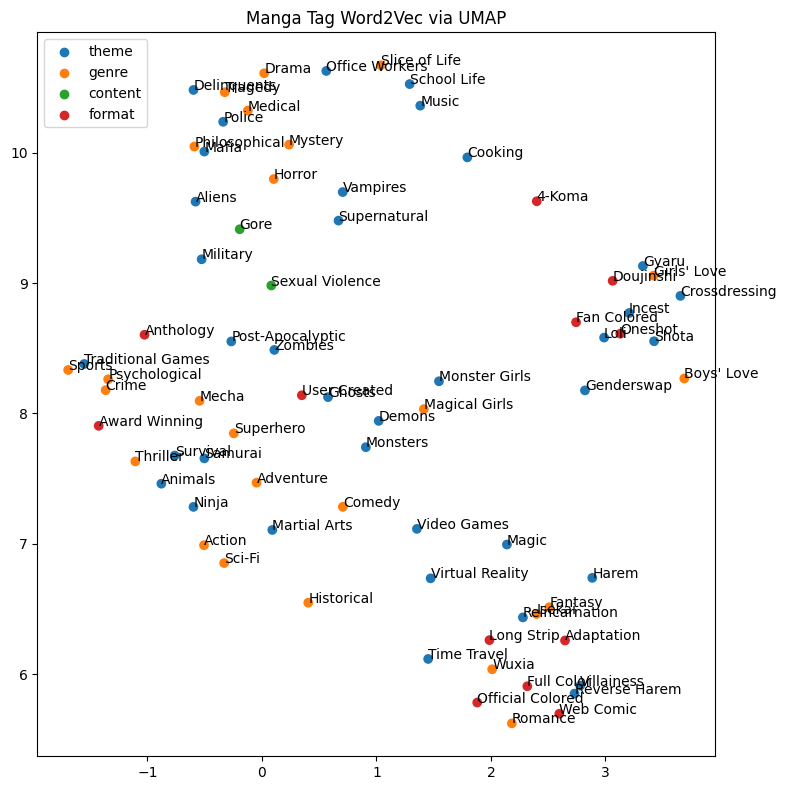

In [74]:
# now one last time but with umap
import umap

# create a color map for each group: genre, format, content, theme
# use a color pallette by default
group_colors = {
    "theme": "tab:blue",
    "genre": "tab:orange",
    "content": "tab:green",
    "format": "tab:red",
}

reducer = umap.UMAP(n_components=2, random_state=0, metric="cosine")
tag_vectors_2d = reducer.fit_transform(tag_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    tag_vectors_2d[:, 0], tag_vectors_2d[:, 1], c=tag_counts["group"].map(group_colors)
)

# show which color maps to each
for group, color in group_colors.items():
    ax.scatter([], [], c=color, label=group)

# now annotate
for i, tag in enumerate(tag_counts["name"]):
    ax.annotate(tag, (tag_vectors_2d[i, 0], tag_vectors_2d[i, 1]))

ax.set_title("Manga Tag Word2Vec via UMAP")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [21]:
# now we average word vectors for each manga
from functools import partial


def average_tag_vectors(model, tags):
    """Given a gensim w2v model and list of tags, return the average vector for
    all tags."""
    return np.mean([model.wv[tag] for tag in tags], axis=0).tolist()


# also could be done in pyspark:
#  F.udf(partial(average_tag_vectors, model), "array<float>")("tags")
manga_tags["w2v"] = manga_tags.tags.apply(partial(average_tag_vectors, model))
manga_tags.head()

,id,tags,w2v
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]","[1.066296935081482, -0.5437330603599548, 0.997..."
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]","[1.6423574686050415, 0.1697539985179901, 1.809..."
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]","[0.6491130590438843, -0.21608895063400269, 0.5..."
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]","[-0.5688261985778809, 0.23230786621570587, 0.6..."
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ...","[0.40054282546043396, -0.20432506501674652, 0...."


In [58]:
from pynndescent import NNDescent

# NOTE: distances in word2vec are cosine distances
tag_index = NNDescent(tag_vectors, metric="cosine")
indices, _ = tag_index.query([model.wv["Isekai"]], k=5)
tag_counts.iloc[indices[0]]

,group,name,n
27,genre,Isekai,2112
22,theme,Magic,2860
64,theme,Villainess,415
17,format,Adaptation,4225
34,theme,Reincarnation,1708


In [60]:
# lets create a genre matrix
genre_counts = tag_counts[tag_counts.group == "genre"].reset_index()
genre_vector = np.array([model.wv[tag] for tag in genre_counts.name])

genre_index = NNDescent(genre_vector, metric="cosine")
indices, _ = genre_index.query([model.wv["Isekai"]], k=5)
genre_counts.iloc[indices[0]]

f:\code\mangadex\.venv\lib\site-packages\pynndescent\pynndescent_.py:936: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(


,index,group,name,n
15,27,genre,Isekai,2112
21,65,genre,Wuxia,365
4,6,genre,Fantasy,12470
7,14,genre,Adventure,7232
24,70,genre,Magical Girls,308


In [61]:
# add a primary genre to each manga
def get_closest(index, mapping, query_vector):
    indices, _ = index.query([query_vector], k=1)
    return mapping[indices[0][0]]


manga_tags["closest_genre"] = manga_tags.w2v.apply(
    partial(get_closest, genre_index, genre_counts.name)
)
manga_tags.head()

,id,tags,w2v,closest_genre
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]","[1.066296935081482, -0.5437330603599548, 0.997...",Drama
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]","[1.6423574686050415, 0.1697539985179901, 1.809...",Superhero
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]","[0.6491130590438843, -0.21608895063400269, 0.5...",Comedy
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]","[-0.5688261985778809, 0.23230786621570587, 0.6...",Boys' Love
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ...","[0.40054282546043396, -0.20432506501674652, 0....",Tragedy


In [63]:
manga_tags.groupby("closest_genre").count()[["w2v"]].sort_values(
    by="w2v", ascending=False
).head()

,w2v
closest_genre,
Magical Girls,7712
Medical,7081
Wuxia,6046
Slice of Life,5635
Boys' Love,5011


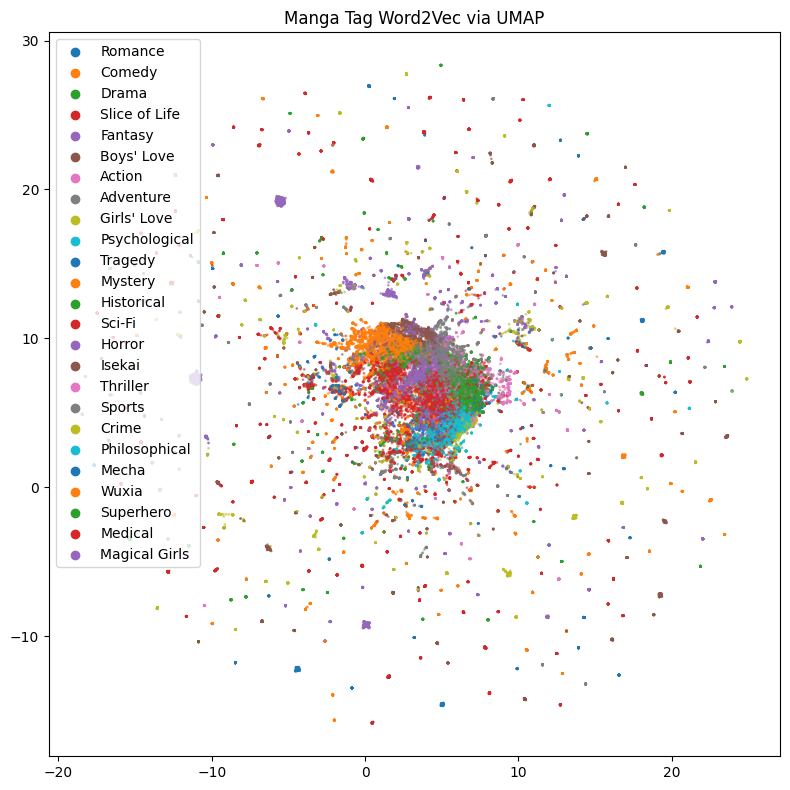

In [80]:
# now plot manga w2v using the closest genre as a color
reducer = umap.UMAP(n_components=2, random_state=0, metric="cosine")
manga_vectors = np.array(manga_tags.w2v.tolist())
manga_vectors_2d = reducer.fit_transform(manga_vectors)

# create a new color map for each genre using their indices
# map to HSV colormap
genre_colors = {genre: f"C{i}" for i, genre in enumerate(genre_counts.name)}

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    manga_vectors_2d[:, 0],
    manga_vectors_2d[:, 1],
    c=manga_tags.closest_genre.map(genre_colors),
    s=1,
    alpha=0.5,
)

# show which color maps to each
for genre, color in genre_colors.items():
    ax.scatter([], [], c=color, label=genre)

ax.set_title("Manga Tag Word2Vec via UMAP")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

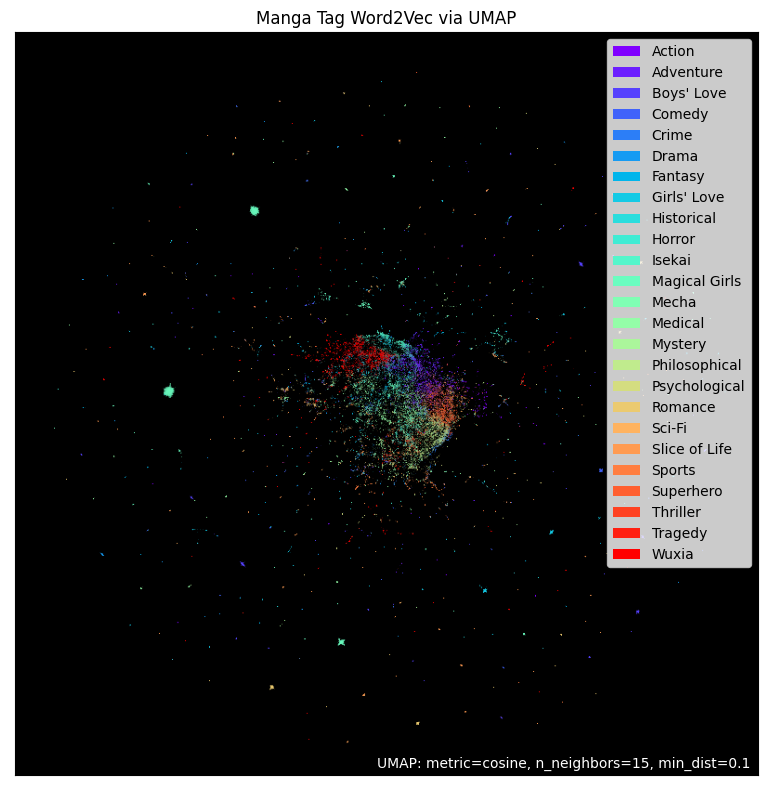

In [85]:
# lets also plot using umap.plot.points
import umap.plot

fig, ax = plt.subplots(figsize=(8, 8))
umap.plot.points(
    reducer,
    labels=manga_tags.closest_genre,
    theme="fire",
    ax=ax,
)

ax.set_title("Manga Tag Word2Vec via UMAP")
plt.tight_layout()
plt.show()

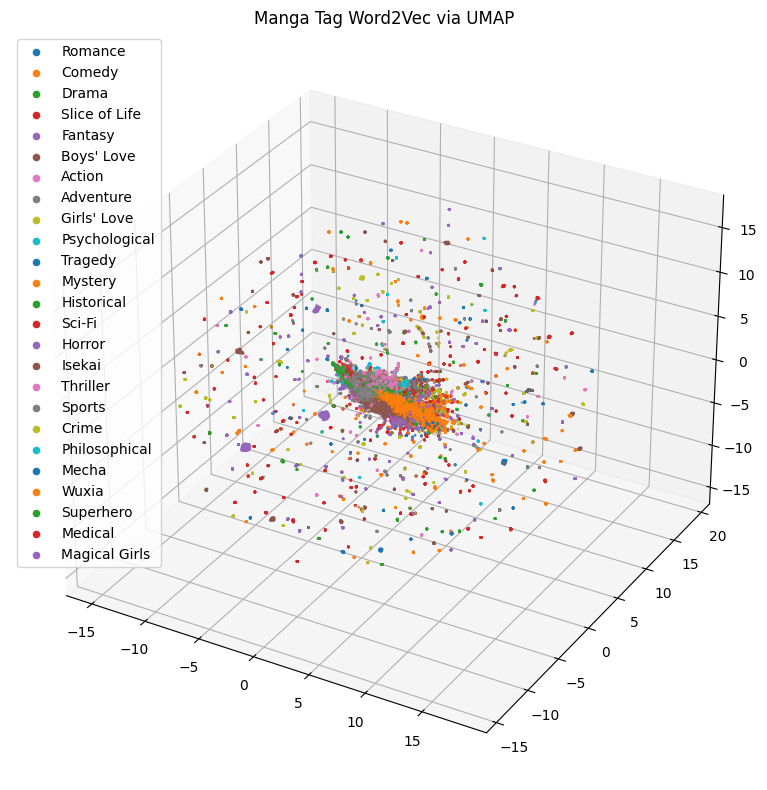

In [72]:
# lets build a 3d scatterplot using umap

reducer = umap.UMAP(n_components=3, random_state=0, metric="cosine")
manga_vectors_3d = reducer.fit_transform(manga_vectors)

# create a new color map for each genre using their indices
genre_colors = {genre: f"C{i}" for i, genre in enumerate(genre_counts.name)}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    manga_vectors_3d[:, 0],
    manga_vectors_3d[:, 1],
    manga_vectors_3d[:, 2],
    c=manga_tags.closest_genre.map(genre_colors),
    s=1,
    alpha=0.5,
)

# show which color maps to each
for genre, color in genre_colors.items():
    ax.scatter([], [], c=color, label=genre)

ax.set_title("Manga Tag Word2Vec via UMAP")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

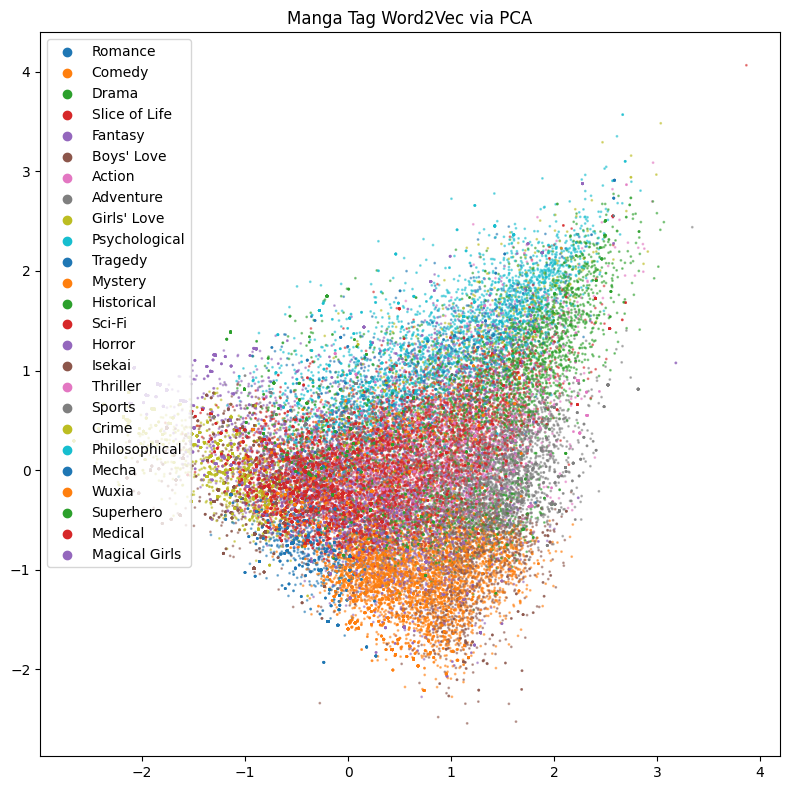

In [68]:
# plot using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
manga_vectors_2d = pca.fit_transform(manga_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    manga_vectors_2d[:, 0],
    manga_vectors_2d[:, 1],
    c=manga_tags.closest_genre.map(genre_colors),
    s=1,
    alpha=0.5,
)

# show which color maps to each
for genre, color in genre_colors.items():
    ax.scatter([], [], c=color, label=genre)

ax.set_title("Manga Tag Word2Vec via PCA")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

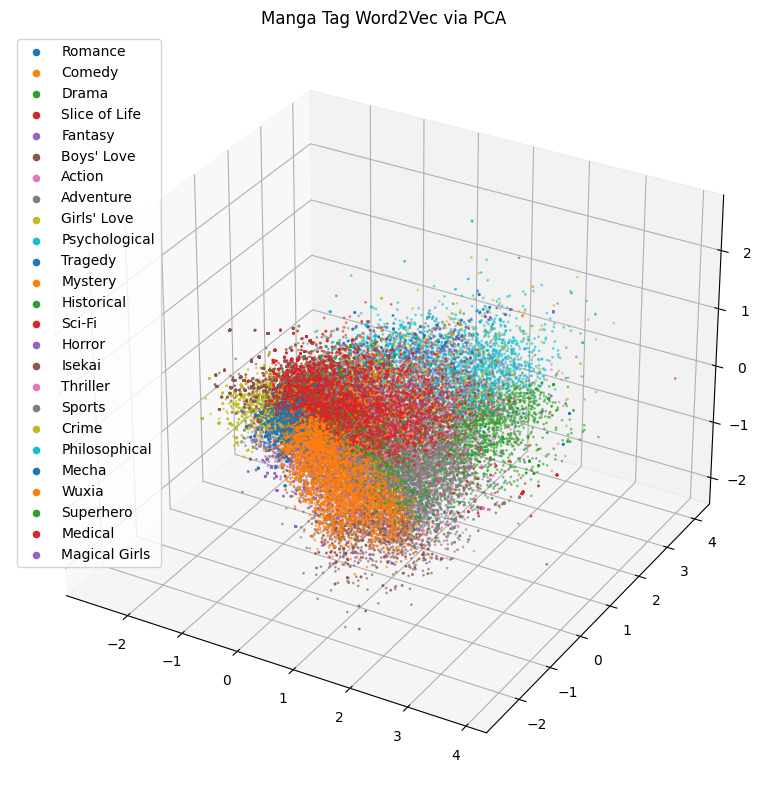

In [73]:
# pca in 3d

pca = PCA(n_components=3)
manga_vectors_3d = pca.fit_transform(manga_vectors)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    manga_vectors_3d[:, 0],
    manga_vectors_3d[:, 1],
    manga_vectors_3d[:, 2],
    c=manga_tags.closest_genre.map(genre_colors),
    s=1,
    alpha=0.5,
)

# show which color maps to each
for genre, color in genre_colors.items():
    ax.scatter([], [], c=color, label=genre)

ax.set_title("Manga Tag Word2Vec via PCA")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

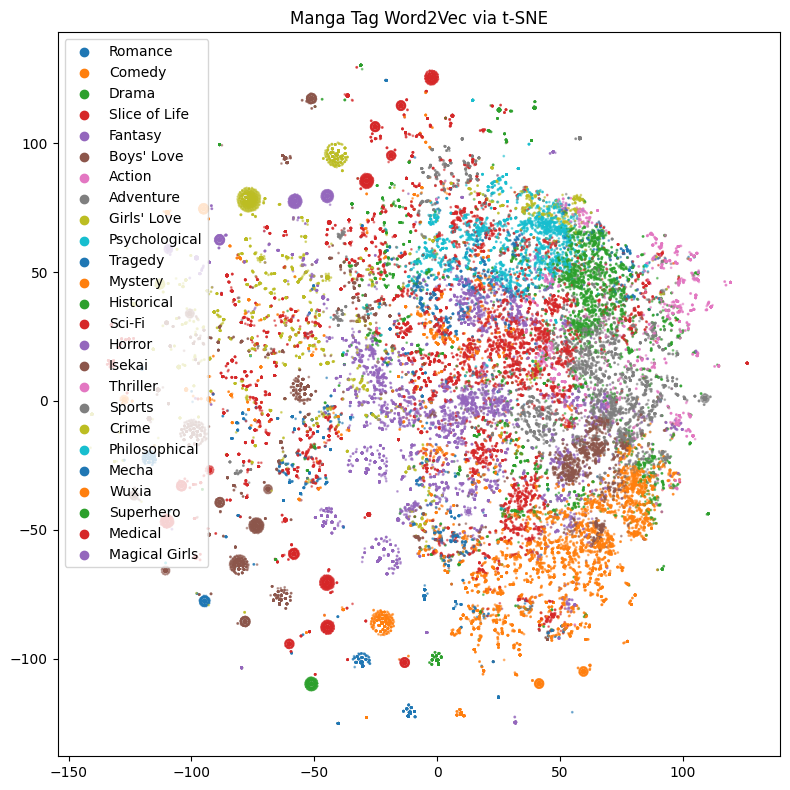

In [86]:
# lets try t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, metric="cosine")
manga_vectors_2d = tsne.fit_transform(manga_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    manga_vectors_2d[:, 0],
    manga_vectors_2d[:, 1],
    c=manga_tags.closest_genre.map(genre_colors),
    s=1,
    alpha=0.5,
)

# show which color maps to each
for genre, color in genre_colors.items():
    ax.scatter([], [], c=color, label=genre)

ax.set_title("Manga Tag Word2Vec via t-SNE")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()